<a href="https://colab.research.google.com/github/Anjaliii7/Pawdentify-Dog-Breed-Identifier/blob/main/dog_breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"anjlii7","key":"3b733af94566d9ea91c425eb74236a90"}'}

In [47]:
!pip install -q kaggle

In [48]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json   # this permission change avoids a warning on kaggle tool startup

In [49]:
#creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset


mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [50]:
#searching kaggle for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                         size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  ----------  --------------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp   724495926  2020-06-26 03:09:05.433000           8091         10  0.1764706        


In [51]:
#downloading the dataset and come out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 96% 666M/691M [00:11<00:00, 89.6MB/s]
100% 691M/691M [00:11<00:00, 64.7MB/s]
/content


In [52]:
#unzipping the downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Archive:  dog_dataset/dogbreedidfromcomp.zip
replace dog_dataset/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: rm: cannot remove 'dog_dataset/sample_submission.csv': No such file or directory


In [53]:
#this is ANN Multilclass model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [54]:
#read the labels.csv file
data=pd.read_csv("dog_dataset/labels.csv")
data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [55]:
data.shape

(10222, 2)

In [56]:
breed=data['breed'].value_counts()
breed.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [57]:
# here i an taking only few dog breeds due to limited computational power
dog_class=['scottish_deerhound','maltese_dog','afghan_hound','entlebucher','bernese_mountain_dog']
labels=data[data['breed'].isin(dog_class)]
labels=labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


In [58]:
labels_onehot=pd.get_dummies(labels['breed'])
labels_onehot.head()

,afghan_hound,bernese_mountain_dog,entlebucher,maltese_dog,scottish_deerhound
0,False,False,False,False,True
1,False,False,False,True,False
2,False,False,False,False,True
3,False,False,True,False,False
4,False,False,True,False,False


In [59]:
#as we are working on clasificaton dataset first we need to onehot encode the target value i.e the dog classes and convert them into numpy array and finally normalize it
x_data=np.zeros((len(labels),224,224,3),dtype='float32')

#one hot encoding
y_data=label_binarize(labels['breed'],classes=dog_class)

In [60]:
#reading and converting image to numpy array
for i in tqdm(range(len(labels))):
  img=image.load_img('dog_dataset/train/'+labels['id'][i]+'.jpg',target_size=(224,224))
  img=image.img_to_array(img)
  x_data[i]=img/255.0

100%|██████████| 588/588 [00:01<00:00, 296.38it/s]


In [61]:
print("Trained image shape:",x_data.shape,'size:{:,}'.format(x_data.size))
print("One hot encoded output shape:",y_data.shape,'size:{:,}'.format(y_data.size))

Trained image shape: (588, 224, 224, 3) size:88,510,464
One hot encoded output shape: (588, 5) size:2,940


In [62]:
#building the model
from keras.constraints import MaxNorm

model=Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',input_shape=(224,224,3))) # Input shape should be 3 for RGB images
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_constraint=MaxNorm(2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_constraint=MaxNorm(2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=8,kernel_size=(3,3),activation='relu',kernel_constraint=MaxNorm(2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_constraint=MaxNorm(2)))
model.add(Dense(64,activation='relu',kernel_constraint=MaxNorm(2)))
model.add(Dense(len(dog_class),activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,277 (723.74 KB)

 Trainable params: 185,277 (723.74 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
#split data into training and testing data
x_train_val,x_test,y_train_val,y_test=train_test_split(x_data,y_data,test_size=0.1)

#split training data into training and validation data
x_train,x_val,y_train,y_val=train_test_split(x_train_val,y_train_val,test_size=0.2)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # watch validation loss
    patience=10,               # stop if no improvement for 5 epochs
    restore_best_weights=True # roll back to best model
)

In [66]:
#training the model
epochs=50
batch_size=64
history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),callbacks=[early_stop])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.2006 - loss: 1.6166 - val_accuracy: 0.1509 - val_loss: 1.6170
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.2494 - loss: 1.5957 - val_accuracy: 0.1887 - val_loss: 1.6135
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.2289 - loss: 1.5929 - val_accuracy: 0.2075 - val_loss: 1.6081
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.2650 - loss: 1.5848 - val_accuracy: 0.2264 - val_loss: 1.6039
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.2862 - loss: 1.5714 - val_accuracy: 0.2642 - val_loss: 1.5928
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.3090 - loss: 1.5575 - val_accuracy: 0.2736 - val_loss: 1.5769
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.3295 - loss: 1.5225 - val_accuracy: 0.3302 - val_loss: 1.5645
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.3715 - loss: 1.4981 - val_accuracy: 0.3774 - val_loss: 1.5386
Epoch 9/

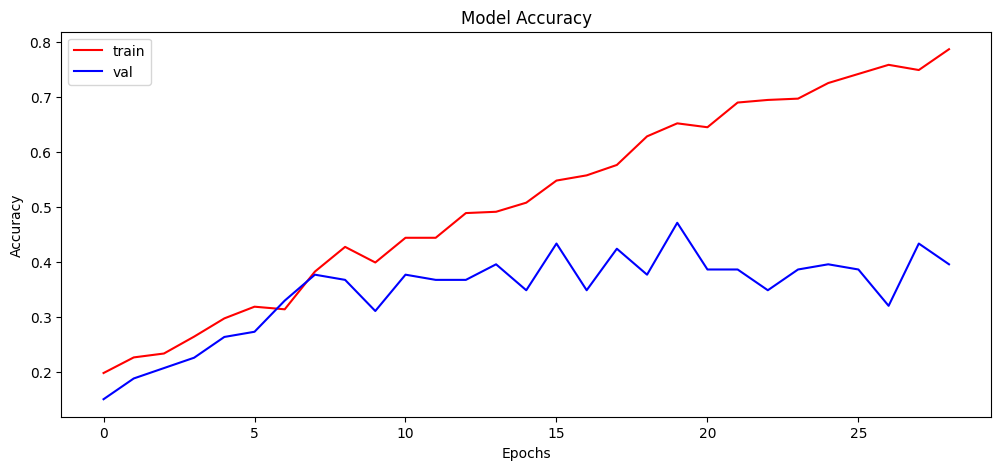

In [67]:
# now analyse how the model is learning with each epoch in terms of accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [68]:
y_pred=model.predict(x_test)
score=model.evaluate(x_test,y_test)
print('Test Accuracy : {:.2f}%'.format(score[1]*100))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5282 - loss: 1.2748   
Test Accuracy : 54.24%


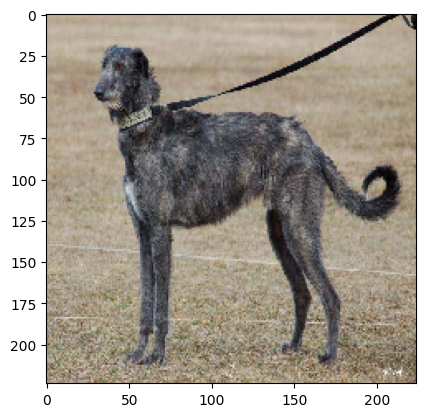

Original : scottish_deerhound
Predicted : scottish_deerhound


In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Set the index of the image you want to display
image_index = 10  # Change this value to display a different image

plt.imshow(x_test[image_index,:,:,:])
plt.show()

print("Original :", labels['breed'][np.argmax(y_test[image_index])])
print("Predicted :", labels['breed'][np.argmax(y_pred[image_index])])

In [76]:
model.save("dog_breed.keras")

In [77]:
from google.colab import files
files.download("dog_breed.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>